# ConvNeXt on FashionMNIST 
__(MaxPlus MLP)__

## Setup

In [1]:
import torch
import torch.nn as nn
import timm
import timm.data
import random
import os
from timm.scheduler.cosine_lr import CosineLRScheduler
import semitorch
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc
import numpy as np
from IPython import display
from tqdm.notebook import tqdm, trange
from itertools import chain
from semitorch import MultiOptimizer, MultiLRScheduler

# Reproducibility
RNG_SEED = 43
torch.manual_seed(RNG_SEED)
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# Helper functions

def get_lr_per_epoch(scheduler, num_epoch):
    lr_per_epoch = []
    for epoch in range(num_epoch):
        lr_per_epoch.append(scheduler._get_values(epoch))
    return lr_per_epoch

def resetmodel(model: nn.Module) -> None:
    @torch.no_grad()
    def weight_reset(m: nn.Module):
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()

    model.apply(fn=weight_reset)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# path to data sets and device to work on
data_path = os.path.abspath("./data" if os.path.isdir("./data") else "../data")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"data path = {data_path}\ndevice = {device}")

[Taichi] version 1.7.0, llvm 15.0.4, commit 2fd24490, linux, python 3.11.5


[I 12/18/23 09:18:04.251 162008] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=cuda
data path = /home/bmnsmets/Documents/semitorch/data
device = cuda


In [2]:
# Load FashionMNIST dataset
transforms_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
        transforms.Resize((16, 16), antialias=True),
        # transforms.RandomResizedCrop(
        #     (16, 16), scale=(0.9, 1.0), ratio=(0.9, 1.1), antialias=True
        # ),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
        transforms.Resize((16, 16), antialias=True),
    ]
)

fashion_train = FashionMNIST(
    root=data_path, train=True, download=True, transform=transforms_train
)
fashion_test = FashionMNIST(
    root=data_path, train=False, download=True, transform=transforms_test
)

fashion_num_features = fashion_test[0][0].shape[1] * fashion_test[0][0].shape[1]
fashion_num_classes = torch.unique(fashion_test.targets).shape[0]

print(
    f"FashionMNIST dataset: input features = {fashion_test[0][0].shape[1]}x{fashion_test[0][0].shape[1]}, classes = {torch.unique(fashion_test.targets).shape[0]}, samples = {len(fashion_train)}"
)

FashionMNIST dataset: input features = 16x16, classes = 10, samples = 60000


In [3]:
batch_size = 512
num_workers = 0

g = torch.Generator()
g.manual_seed(RNG_SEED)

fashion_train_loader = DataLoader(
    fashion_train,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    num_workers=num_workers,
)
fashion_test_loader = DataLoader(
    fashion_test, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

## Model

In [4]:
convnext_st_maxplusmlp_atto = timm.create_model(
    "convnext_st_maxplusmlp_atto",
    in_chans=1,
    patch_size=1,
    num_classes=10,
)
convnext_st_maxplusmlp_atto = convnext_st_maxplusmlp_atto.to(device)

print(
    f"convnext_st_maxplusmlp_atto has {count_parameters(convnext_st_maxplusmlp_atto):,} parameters"
)

def check_parameter_count(m):
    linear = sum(p.numel() for p in m.linear_parameters() if p.requires_grad)
    nonlinear = sum(p.numel() for p in m.nonlinear_parameters() if p.requires_grad)
    total = sum(p.numel() for p in m.parameters() if p.requires_grad)
    assert total == linear + nonlinear
    return

#check_parameter_count(convnext_st_maxplusmlp_atto)

convnext_st_maxplusmlp_atto has 3,375,850 parameters


In [5]:
#convnext_st_maxplusmlp_atto(fashion_train[0][0].to(device))

## Training

In [6]:
def accuracy(model, x, y):
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)
        return (y==prediction).sum().item() / float(y.numel())


def test(model, device, testloader):
    model.eval()
    accs = []
    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))
    return sum(accs)/len(accs)


def train(model, device, trainloader, testloader, optimizer, scheduler, loss, epochs):
    accs = [] # list of accuracy on the test dataset for every epoch
    trainaccs = [] # a list of the accuracies of all the training batches
    epoch_len = len(trainloader)

    fig, ax = plt.subplots(1, 1, figsize=[4,3])
    hdisplay = display.display("", display_id=True)

    for epoch in trange(epochs):
        model.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu()==prediction).sum().item() / float(y.numel()))
            l = loss(yout, y)
            l.backward()
            optimizer.step()
            if scheduler != None:
                scheduler.step(epoch)

        accs.append(test(model, device, testloader))

        ax.clear()
        ax.set_xlim(0, epochs)
        ax.set_ylim(0.75, 1.0)
        ax.plot(np.linspace(0,len(accs),len(trainaccs)), 
            trainaccs, ".", markersize=1.5, markerfacecolor=(0, 0, 1, 0.3))
        ax.plot(np.linspace(1,len(accs),len(accs)), accs)
        ax.text(0.6*epochs, 0.80, f"max test acc = {max(accs):.2%}", ha="center", fontsize=10)
        hdisplay.update(fig)
        
        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    plt.close(fig)
    return sum(trainaccs[-epoch_len:]) / len(trainaccs[-epoch_len:]), max(accs)
    

In [21]:
convnext_st_maxplusmlp_atto.reset_parameters()

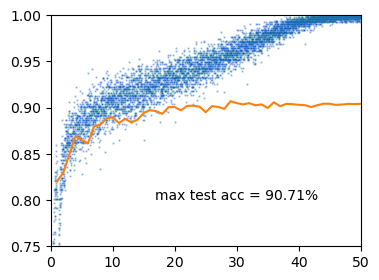

  0%|          | 0/50 [00:00<?, ?it/s]

(0.9980358403954802, 0.9070772058823529)

In [22]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
epochs = 50
model = convnext_st_maxplusmlp_atto
steps_per_epoch = len(fashion_train_loader)

lin_lr = 8e-3
trop_lr = 4e-2
linear_params = model.linear_parameters()
tropical_params = model.nonlinear_parameters()

opt1 = torch.optim.AdamW(linear_params, lr=lin_lr, weight_decay=5e-3)
sch1 = CosineLRScheduler(
    opt1,
    t_initial=epochs,
    warmup_t=5,
    warmup_lr_init=lin_lr/25,
    lr_min=lin_lr/500,
)

opt2 = torch.optim.AdamW(tropical_params, lr=trop_lr, weight_decay=5e-3)
sch2 = CosineLRScheduler(
    opt2,
    t_initial=epochs,
    warmup_t=5,
    warmup_lr_init=trop_lr/25,
    lr_min=trop_lr/500,
)

# opt1 = torch.optim.AdamW(linear_params, lr=lin_lr, weight_decay=0.01)
# sch1 = torch.optim.lr_scheduler.OneCycleLR(
#     opt1,
#     max_lr=lin_lr,
#     anneal_strategy="linear",
#     pct_start=0.45,
#     three_phase=True,
#     final_div_factor=1000.0,
#     div_factor=10.0,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
# )

# opt2 = torch.optim.AdamW(tropical_params, lr=trop_lr, weight_decay=0.01)
# sch2 = torch.optim.lr_scheduler.OneCycleLR(
#     opt2,
#     max_lr=trop_lr,
#     anneal_strategy="linear",
#     pct_start=0.45,
#     three_phase=True,
#     final_div_factor=1000.0,
#     div_factor=10.0,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
# )
optimizer = MultiOptimizer(opt1, opt2)
scheduler = MultiLRScheduler(sch1, sch2)
# base_lr = 4e-3
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=5e-3)
# scheduler = CosineLRScheduler(
#     optimizer,
#     t_initial=epochs,
#     warmup_t=5,
#     warmup_lr_init=base_lr/25,
#     lr_min=base_lr/500,
# )

train(
    convnext_st_maxplusmlp_atto,
    device,
    fashion_train_loader,
    fashion_test_loader,
    optimizer,
    scheduler,
    loss,
    epochs,
)